In [2]:
#Entrada: los datos ya descargados de RASFF y las salidas del "Análisis_full_RASFF_Data".

#Formatos a probar:
#159 paises x 29 productos x 1destino/origen (159x29x1)
#159 paises x 159 paises x 29 productos (159x159x29)
#159 paises x 1 valor producto x 1 destino/origen (159x1x1)
#159paises x 159 paises x 1 valor producto (159x159x1)
#
#Tensor 3D 159x159x29


#Vamos a hacer el de 159x159x1.

# Preprocesamiento 

## Librerías

In [3]:
import numpy as np
import pandas as pd
import stellargraph as sg
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools

from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from sklearn import model_selection
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix

from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras import losses


## Carga del dataset

In [4]:
df = pd.read_csv('./../../Datasets/full_RASFF_DATA.csv', sep=';', header=0, index_col = 0)

#### Carga de los datasets auxiliares (tratamiento)

In [5]:
df_productos = pd.read_csv('./../../Datasets/Lista_Productos.csv', header=0, index_col = 0)
df_cat_productos = pd.read_csv('./../../Datasets/Lista_Categoria_Productos.csv', header=0, index_col = 0)
df_amenazas = pd.read_csv('./../../Datasets/Lista_Amenazas.csv', header=0, index_col = 0)
df_cat_amenazas = pd.read_csv('./../../Datasets/Lista_Categoria_Amenazas.csv', header=0, index_col = 0)
df_repes = pd.read_csv('./../../Datasets/Lista_repeticion_paises.csv', header=0, index_col = 0)

#### Conversión de NaN a formato string

In [6]:
df = df.replace(np.nan, "", regex=True)

## Corrección del dataset

In [7]:
#Seleccionamos la primera categoría de amenaza entre todas las posibles
for index, row in df.iterrows():
    row['HAZARDS_CAT'] = row['HAZARDS_CAT'].split(",")[0]

## Elección de fechas

In [8]:
len(df_cat_amenazas)

33

In [9]:
#Eliminamos las fechas que no nos interesan.
fecha_maxima = "2021" #Primer año que no queremos coger.
df = df.loc[df['DATE_CASE'] < fecha_maxima]

In [10]:
len(df)

61350

## Agrupación de clases

In [11]:
#Segun el dendograma visto anteriormente, vamos a agrupar las clases 
#"labelling absent/incomplete/incorrect" con "packaging defective / incorrect"
#bajo una nueva clase llamada "labelling absent/packaging defective/incorrect"

for index, row in df.iterrows():
    if(row['HAZARDS_CAT'] == "labelling absent/incomplete/incorrect" or row['HAZARDS_CAT'] == "packaging defective / incorrect"):
        row['HAZARDS_CAT'] = "labelling absent/packaging defective/incorrect"

## Eliminamos los registros que no deseamos 
Las categorias obsoletas y los países con una tasa de participación inferior al 1%

In [12]:
paises_eliminar = df_repes.tail(72)
cat_productos_eliminar = df_cat_productos.tail(16)
cat_productos_eliminar = cat_productos_eliminar.append(df_cat_productos.iloc[-22])
cat_productos_eliminar = cat_productos_eliminar.sort_values('Repeticiones', ascending = False)
cat_amenazas_eliminar = df_cat_amenazas.tail(19) #Estaba en 19

In [13]:
len(df)

61350

In [14]:
#df_cat_amenazas.tail(50)

In [15]:
#Eliminamos los registros que contienen valores no interesantes para nuestro estudio, mirando en las columnas de interés en cada registro.

#Guardamos las filas que no queremos coger en este datframe.
df_eliminar = df.drop(df.index, inplace=False)

#Buscamos esas filas "inútiles".
for index, row in df.iterrows():
    #Eliminamos los países invalidos.
    for j in (row["COUNT_ORIGEN"].split(",")):
        if (j in paises_eliminar['Pais'].values or j == "INFOSAN" or j == "Commission Services"):
            df_eliminar.loc[df_eliminar.shape[0]] = row
    for j in (row["COUNT_CONCERN"].split(",")):
        if (j in paises_eliminar['Pais'].values or j == "INFOSAN" or j == "Commission Services"):
            df_eliminar.loc[df_eliminar.shape[0]] = row
    for j in (row["COUNT_DESTIN"].split(",")):
        if (j in paises_eliminar['Pais'].values or j == "INFOSAN" or j == "Commission Services"):
            df_eliminar.loc[df_eliminar.shape[0]] = row
    #Eliminamos los productos inválidos.
    if (row["PROD_CAT"] in cat_productos_eliminar['Cat_Producto'].values):
        df_eliminar.loc[df_eliminar.shape[0]] = row
    #Eliminamos las categorías de amenazas inválidas.
    for j in (row["HAZARDS_CAT"].split(",")):
        if (j in cat_amenazas_eliminar['Cat_Amenaza'].values 
            or row["HAZARDS_CAT"] == ""
            or row["HAZARDS_CAT"] == " "):
            df_eliminar.loc[df_eliminar.shape[0]] = row
    #Eliminamos los registros que están vacios y no tienen información acerca de los paises.
    if((row["COUNT_ORIGEN"] == " " or row["COUNT_ORIGEN"] == "") 
       and (row["COUNT_CONCERN"] == " " or row["COUNT_CONCERN"] == "") 
       and (row["COUNT_DESTIN"] == " " or row["COUNT_DESTIN"] == "")):
        df_eliminar.loc[df_eliminar.shape[0]] = row
        
#Eliminamos por columna REF.
cond = df['REF'].isin(df_eliminar['REF'])
df.drop(df[cond].index, inplace = True)

In [16]:
len(df)

47214

## Undersampling y conjunto de test

In [17]:
#Debido al gran desequilibrio entre clases, equilibramos los datos con técnicas de undersampling.
num_max_clase = 1700      #Número de registros máximo por clase.
num_registros_test = 200  #Número de registros por clase para el conjunto de testeo.

#Creamos una lista con todos los dataframes según cada clase para hacer el undersampling.
ans = [pd.DataFrame(y) for x, y in df.groupby('HAZARDS_CAT', as_index=False)]

#Creamos el conjunto de test por clases (sin seleccionar las columnas deseadas). Seleccionando 200 casos de todas las clases de forma random.
listaClasesTest = ans.copy()
for i in range(len(listaClasesTest)):
    listaClasesTest[i] = listaClasesTest[i].sample(n=num_registros_test)

#Escogemos la cantidad máxima de registros por cada clase.
for i in range(len(ans)):
    if(ans[i]['HAZARDS_CAT'].count() > num_max_clase):
        ans[i] = ans[i].sample(n=num_max_clase)
        
#Reunimos todos en un único datframe (df otra vez).
df = pd.concat(ans)
testRowData = pd.concat(listaClasesTest)

#Hacemos un shuffle para mezclar las clases entre sí.
df = df.sample(frac=1).reset_index(drop=True)

## Selección de atributos

In [18]:
#Creamos 2 datasets, uno con los parámetros a entrenar (df) y otro con la información relativa a cada registro (df_info)
df_info = df[['REF','PRODUCT','HAZARDS','DATE_CASE','CLASSIF','TYPE','RISK_DECISION', 'ACTION_TAKEN','DISTRIBUTION_STAT','NOT_COUNTRY']].reset_index(drop = True)
df = df[['PROD_CAT','HAZARDS_CAT','COUNT_ORIGEN','COUNT_CONCERN','COUNT_DESTIN']].reset_index(drop = True)

#De la misma forma con los datos del conjunto de test. QUEDA PENDIENTE HACER ESTO (TIENE QUE TENER MISMO FORMATO QUE LOS GRAFOS.)
testData = testRowData[['PROD_CAT','HAZARDS_CAT','COUNT_ORIGEN','COUNT_CONCERN','COUNT_DESTIN']].reset_index(drop = True)


In [19]:
len(df)

22220

## One hot encoding

In [20]:
#Sacamos el dataframe de las categorías de amenaza, que es lo que vamos a predecdf_nodes_featuressificar para
#poder compararlos y hacer un entrenamiento supervisado. Empleando OrdinalEncoder

ord_enc = OrdinalEncoder()

#Guardamos los valores temporalmente en y.
y = pd.DataFrame(columns = []) 
y['y_value'] = df['HAZARDS_CAT']
y['y_code'] = ord_enc.fit_transform(y[["y_value"]])

#Creamos un pequeño df "y_guide" con las conversiones, a modo de guía de qué codigo es qué valor.
y_guide = pd.DataFrame(columns = ['y_value','y_code'])
y_guide['y_value'] = y['y_value'].unique()
y_guide['y_code'] = y['y_code'].unique()

#Pasamos al formatpo de graph_labels, que es el que se emplea para las GCNNs.
graph_labels = pd.Series(y["y_code"], dtype = "category", name = "Label")

df = df.drop('HAZARDS_CAT', axis=1)

#Hacemos el one hot encoding de las categorías de los productos del df.
x = pd.get_dummies(df['PROD_CAT'], prefix='PROD_CAT_')
#display(x)
#Los valores corresponden a la posición del producto ordenado alfabeticamente y sumado 1.

#Convertimos el producto que corresponde al peso de los grafos
x = df['PROD_CAT'].astype('category').cat.codes
x = pd.DataFrame(data=x, columns = ['weight'], dtype = np.float32)
x['weight'] += 1 #Para que no haya un 0 como peso.
#print(x)
#display(y.groupby("y_value").count())

## Creación de los grafos

### Preparación

In [23]:
#Preparación previa. Elegimos los países que vamos a usar (correspondiendo a los que hemos eliminado más arriba).
paises = df_repes.head(159)['Pais'].sort_values().reset_index(drop = True)
paises = paises[1:]          #Quitamos los huecos vacíos " ".

In [24]:
#Preparación previa. Creamos el 158x158x1 y lo rellenamos con los datos, las nuevas matrices.
input_data = np.zeros((len(df),158,158,1))
#input_data = np.empty()

#Bucle que recorra todos los registros, y relacione los nodos entre sí, marcando la relación entre los paises.
for index, row in df.iterrows():
    #Creamos la matriz para un ejemplo.
    matrix = np.zeros((158, 158, 1))

    #Guardamos las longitudes de cada registro (nº de países). Si es vacío, establecemos un 0. 
    #LenCO = Country origen. LenCC = Country Concern y LenCD = Contry Destin.
    if(not row['COUNT_ORIGEN'] == "" and not row['COUNT_ORIGEN'] == " "):
        LenCO = len(row['COUNT_ORIGEN'].split(","))
        paisesCO = row['COUNT_ORIGEN'].split(",")
    else:
        LenCO = 0
        paisesCO = "".split(",")
    if(not row['COUNT_CONCERN'] == "" and not row['COUNT_CONCERN'] == " "):
        LenCC = len(row['COUNT_CONCERN'].split(","))
        paisesCC = row['COUNT_CONCERN'].split(",")
    else:
        LenCC = 0
        paisesCC = "".split(",")
    if(not row['COUNT_DESTIN'] == "" and not row['COUNT_DESTIN'] == " "):
        LenCD = len(row['COUNT_DESTIN'].split(","))
        paisesCD = row['COUNT_DESTIN'].split(",")
    else:
        LenCD = 0 
        paisesCD = "".split(",")
    #Creamos dos bucles anidados, para recorrer todos los source y linkarlos con todos los destinos. 
    #¡Esto funciona porque los índices de df_nodes siguen este mismo orden! 
    #Pero OJO! -> Existen 3 posibles casos: 1) LenCO = 0, 2) LenCC = 0 y 3) LenCD = 0. Teóricamente, habría que hacer 1->2->3.
    #Si los 3 existen y son mayores que 0 se ejecutan los dos bucles.
    
    #Empezamos a rellenar el df, si existe LenCO y LenCC, lo rellenamos. 
    if(LenCO != 0 and LenCC != 0):
        for i in range(LenCO):
            indexOrigen = paises[paises==paisesCO[i]].index[0]-1
            for j in range(LenCC):
                indexDestino = paises[paises==paisesCC[j]].index[0]-1
                matrix[indexOrigen][indexDestino] = np.float32(x.iloc[index][0])              
    #Si LenCD es 0, no pasa nada, el grafo ya está creado. Si sí que existe, seguimos rellenando el grafo.
    if(LenCC != 0 and LenCD != 0):
        for i in range(LenCC):
            indexOrigen = paises[paises==paisesCC[i]].index[0]-1
            for j in range(LenCD):
                indexDestino = paises[paises==paisesCD[j]].index[0]-1
                matrix[indexOrigen][indexDestino] = np.float32(x.iloc[index][0])                  
    #Por aquí solo va a entrar si no ha entrado en los otros dos.
    if(LenCC == 0):
        for i in range(LenCO):
            indexOrigen = paises[paises==paisesCO[i]].index[0]-1
            for j in range(LenCD):
                indexDestino = paises[paises==paisesCD[j]].index[0]-1
                matrix[indexOrigen][indexDestino] = np.float32(x.iloc[index][0])              

    #Insertamos la matriz en la lista de datos.
    input_data[index] = matrix
    

In [25]:
np.shape(input_data)

(22220, 158, 158, 1)

### Ejemplo visual

In [26]:
#Ejemplos para enseñar
miniIndex = 10
pd.set_option('display.max_columns', None)

display(df.iloc[miniIndex])
display(input_data[miniIndex].shape)
#display(graph_labels[miniIndex])
#display(y_guide[y_guide['y_code']==graph_labels[miniIndex]]['y_value'][0])

PROD_CAT         crustaceans and products thereof
COUNT_ORIGEN                                China
COUNT_CONCERN                   Netherlands,Spain
COUNT_DESTIN                                     
Name: 10, dtype: object

(158, 158, 1)

## Entrenamiento

In [27]:
## Escoger train dataset, validation y test.

In [28]:
X_train, X_Validation = model_selection.train_test_split(
    input_data, train_size=0.68, test_size=None #graph_labels, train_size=0.75, test_size=None, stratify=graph_labels,
)

In [29]:
#División del conjunto de test y validación.
X_Test = X_Validation[int(len(X_Validation)/2):] #el último 0.16 para test graphs
X_Validation = X_Validation[:int(len(X_Validation)/2)] #el primer 0.16 para val graphs

#display(graph_labels[:len(train_graphs)].value_counts())
#display(graph_labels[len(train_graphs):(len(train_graphs) + len(val_graphs))].value_counts())
#display(graph_labels[(len(train_graphs) + len(val_graphs)):].value_counts())

display(len(X_train))
display(len(X_Validation))
display(len(X_Test))

15109

3555

3556

In [30]:
#Convertimos el formato de graph labels.
graph_labels = graph_labels.to_numpy(dtype=int)
type(graph_labels[1])

numpy.int32

In [31]:
#Entrenamiento
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [33]:
model = models.Sequential()
model.add(layers.Conv2D(2, (2, 2), input_shape=((158, 158, 1))))
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(4, (2, 2)))
model.add(layers.LeakyReLU())
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64))
model.add(layers.LeakyReLU())
model.add(layers.Dense(15, activation='softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 157, 157, 2)       10        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 157, 157, 2)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 78, 78, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 4)         36        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 77, 77, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 23716)             0         
_________________________________________________________________
dropout (Dropout)            (None, 23716)             0

In [35]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



In [36]:
display(np.shape(X_train))
display(np.shape(graph_labels[:len(X_train)]))


(15109, 158, 158, 1)

(15109,)

In [37]:
history = model.fit(X_train, graph_labels[:len(X_train)], epochs=60, 
                    validation_data=(X_Validation, graph_labels[len(X_train):(len(X_train)+len(X_Validation))]))

Epoch 1/60
473/473 [==============================] - 46s 96ms/step - loss: 2.7094 - accuracy: 0.0749 - val_loss: 2.6873 - val_accuracy: 0.0799
Epoch 2/60
473/473 [==============================] - 45s 95ms/step - loss: 2.6307 - accuracy: 0.1201 - val_loss: 2.7030 - val_accuracy: 0.0768
Epoch 3/60
473/473 [==============================] - 46s 96ms/step - loss: 2.5556 - accuracy: 0.1490 - val_loss: 2.7416 - val_accuracy: 0.0726
Epoch 4/60
473/473 [==============================] - 46s 98ms/step - loss: 2.4849 - accuracy: 0.1687 - val_loss: 2.8171 - val_accuracy: 0.0731
Epoch 5/60
473/473 [==============================] - 47s 99ms/step - loss: 2.4246 - accuracy: 0.1873 - val_loss: 2.8622 - val_accuracy: 0.0672
Epoch 6/60
473/473 [==============================] - 47s 99ms/step - loss: 2.3829 - accuracy: 0.1982 - val_loss: 2.9232 - val_accuracy: 0.0684
Epoch 7/60
473/473 [==============================] - 47s 99ms/step - loss: 2.3410 - accuracy: 0.2072 - val_loss: 2.9741 - val_accuracy:

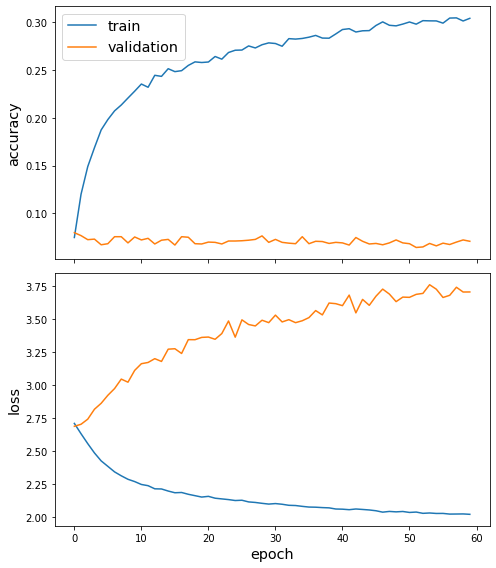

In [38]:
sg.utils.plot_history(history)

In [42]:
Y_prediction = model.predict(X_Test)
y_pred = np.argmax(Y_prediction, axis=1)
y_pred

array([ 4, 14, 11, ...,  9, 14, 14], dtype=int64)

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [46]:
cm = confusion_matrix(graph_labels[(len(X_train)+ len(X_Validation)):], y_pred)

Confusion matrix, without normalization
[[11  9 32  2 18 15  5 33 21  8 19  9 20 10  9]
 [10  5 16  3 11 24  1 23  9 12 16 13 19  8 20]
 [13  7 29  7 33 26  6 26 18  8 22 13 25 10 26]
 [ 8  4 13  1 18 13  2 17  8  8 17 12  9  4 14]
 [14 13 30  1 21 29  3 24 16 14 28 12 33 11 21]
 [ 9 10 25  4 23 17  2 28 17 11 15 16 17  9 21]
 [ 9  6  8  2  6 16  2 10  9  8  4  8 17  9  9]
 [11  8 24  4 18 16  1 37 14 15 33 19 31 15 17]
 [14  7 32  2 27 19  6 36 13 12 24 11 30 20 24]
 [ 9  5 27  1 13 23  3 19 11  8 26 11 22 13 21]
 [ 9 15 39  4 35 22  4 26 17 22 18 17 32 10 20]
 [15  8 38  5 24 25  1 44 12 13 25 14 32 18 22]
 [13 12 25  0 31 18  1 35 27 16 19 18 33 12 22]
 [13  5 19  1 24 22  4 23 17  9 19 12 22 12  8]
 [14  9 30  2 21 25  8 41 16 17 25 12 27 15 19]]


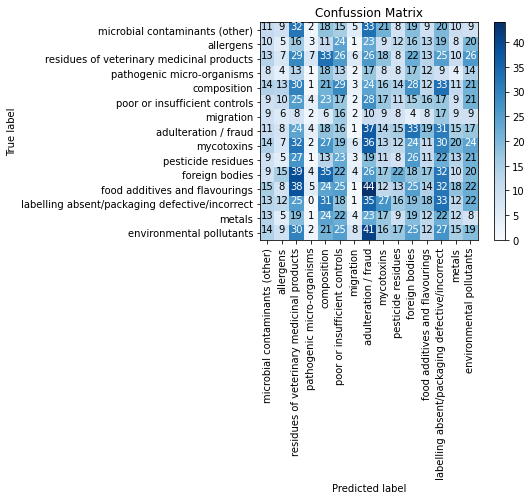

In [47]:
plot_confusion_matrix(cm, y_guide['y_value'], title="Confussion Matrix")

In [50]:
aciertos = 0
total = 0
for i in range(len(cm)):
    for j in range(len(cm[0])):
        total+=cm[i][j]
        if(j == i):
            aciertos += cm[i][j] 

In [51]:
print("Test Set Metrics")
print("acc:",aciertos/total)

Test Set Metrics
acc: 0.06749156355455568


In [52]:
matrix = cm

precision = np.zeros((len(matrix)))
especificidad = np.zeros((len(matrix)))
sensibilidad = np.zeros((len(matrix)))
miAccuracy = 0


sumaHorizontal = np.zeros((len(matrix)))
sumaVertical = np.zeros((len(matrix)))
sumaDiagonal = np.zeros((len(matrix)))

for i in range(len(sumaHorizontal)):
    sumaHorizontal[i] = matrix[i].sum() 
    
for i in range(len(sumaVertical)):
    for j in range(len(sumaVertical)):
        sumaVertical[i] += matrix[j][i]
    
for i in range(len(sumaDiagonal)):
    sumaDiagonal[i] = matrix[i][i]
    
display(sumaHorizontal)
display(sumaVertical)
display(sumaDiagonal)

for i in range(len(precision)):
    precision[i] = matrix[i][i]/sumaVertical[i]
    
for i in range(len(sensibilidad)):
    sensibilidad[i] = matrix[i][i]/sumaHorizontal[i]
    
for i in range(len(especificidad)):
    especificidad[i] = (sumaDiagonal[:i].sum()+sumaDiagonal[(i+1):].sum())/(sumaHorizontal[:i].sum()+sumaHorizontal[(i+1):].sum())
    
miAccuracy = sumaDiagonal.sum()/sumaHorizontal.sum()
print("")
print("")
print("Métricas de la Matriz de Confusión:")
print("")
print("Accuracy:",miAccuracy)
print("--------------------------------")
print("Precision de la clase:",precision)
print("--------------------------------")
print("Sensibilidad:",sensibilidad)
print("--------------------------------")
print("Especificidad:",especificidad)
print("--------------------------------")

array([221., 190., 269., 148., 270., 224., 123., 263., 277., 212., 290.,
       296., 282., 210., 281.])

array([172., 123., 387.,  39., 323., 310.,  49., 422., 225., 181., 310.,
       197., 369., 176., 273.])

array([11.,  5., 29.,  1., 21., 17.,  2., 37., 13.,  8., 18., 14., 33.,
       12., 19.])



Métricas de la Matriz de Confusión:

Accuracy: 0.06749156355455568
--------------------------------
Precision de la clase: [0.06395349 0.04065041 0.0749354  0.02564103 0.06501548 0.05483871
 0.04081633 0.08767773 0.05777778 0.0441989  0.05806452 0.07106599
 0.08943089 0.06818182 0.06959707]
--------------------------------
Sensibilidad: [0.04977376 0.02631579 0.10780669 0.00675676 0.07777778 0.07589286
 0.01626016 0.14068441 0.04693141 0.03773585 0.06206897 0.0472973
 0.11702128 0.05714286 0.06761566]
--------------------------------
Especificidad: [0.06866567 0.06981581 0.06419227 0.07012911 0.06664638 0.06692677
 0.06932712 0.06164592 0.06922842 0.06937799 0.06797306 0.06932515
 0.06322541 0.06814106 0.06748092]
--------------------------------
